In [111]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [112]:
# global imports and global vars
import pandas as pd
import time
from sklearn.metrics import accuracy_score

performanceList = [0] *  5

time_to_train = [0] * 5
time_to_predict = [0] * 5

In [113]:
# Step1: read the files and clean data
data = pd.read_csv("data/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
target = pd.read_csv("../input/titanic/gender_submission.csv")

data.head(10)

def clean(data):
    data = data.drop(["Ticket", "Cabin", "Name", "PassengerId"], axis = 1)
    
    cols = ["SibSp", "Parch", "Fare", "Age"]
    for col in cols:
        data[col].fillna(data[col].median(), inplace = True)
    
    data.Embarked.fillna("U", inplace = True)
    return data

data = clean(data)
# test = clean(test)

data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,28.0,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


In [114]:
# Step2: preprocessing the data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
le = preprocessing.LabelEncoder()

cols = ["Sex", "Embarked"]

for col in cols:
    data[col] = le.fit_transform(data[col]) # call fit_transform() in training data
    # test[col] = le.transform(test[col])     # call transform() in test data

# split data into training set and testing set
X = data[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]
y = data["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=123)


In [115]:
y_train.head(5)

416    1
801    1
512    1
455    1
757    0
Name: Survived, dtype: int64

In [116]:
from sklearn import tree
from sklearn.model_selection import validation_curve
import numpy as np
import matplotlib.pyplot as plot

# Step3: Models

# Step3.a: Decision Tree
decisionTreeClassifier_initial = tree.DecisionTreeClassifier()

def plotFigure_plot(title, xLabel, xRange, yLabel, xTicks, saveAsName):
    plot.figure()
    plot.plot(xRange, np.mean(train_scores, axis=1), label = "Train Score")
    plot.plot(xRange, np.mean(test_scores, axis=1), label = "CV Score") 
    plot.legend()
    plot.title(title)
    plot.xlabel(xLabel)
    plot.ylabel(yLabel)
    plot.xticks(xTicks)
    plot.grid()
    plot.savefig(saveAsName)
    plot.show()

def plotFigure_label(title, xLabel, xRange, yLabel, xTicks, saveAsName):
    plot.figure()
    xRange = xRange
    plot.plot(xRange, np.mean(train_scores, axis=1), label = "Train Score")
    plot.plot(xRange, np.mean(test_scores, axis=1), label = "CV Score") 
    plot.legend()
    plot.title(title)
    plot.xlabel(xLabel)
    plot.ylabel(yLabel)
    plot.xticks(xRange, xTicks)
    plot.grid()
    plot.savefig(saveAsName)
    plot.show()

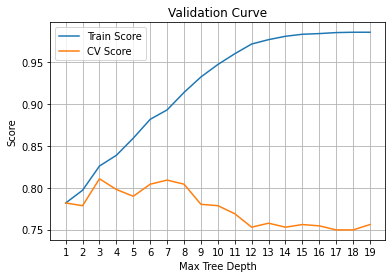

In [117]:
# Step 3.a: Decision Tree - Tree depth
# param_range np.arange(1,20), has tried several diff options, this is good enough to show the "trend"
train_scores, test_scores = validation_curve(decisionTreeClassifier_initial, X_train, y_train, param_name = 'max_depth', param_range = np.arange(1,20))
    
plotFigure_plot("Validation Curve", "Max Tree Depth", np.arange(1,20), "Score", np.arange(1,20), "titanic_decisionTree_validationCurve_maxDepth.png")

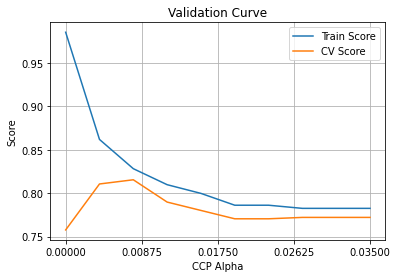

In [118]:
# Step 3.a: Decision Tree - Pruning
# param_range np.linspace(0,0.035,10), the most used? one from what I can found in Internet
train_scores, test_scores = validation_curve(decisionTreeClassifier_initial, X_train, y_train, param_name = 'ccp_alpha', param_range = np.linspace(0,0.035,10))

plotFigure_plot("Validation Curve", "CCP Alpha", np.linspace(0,0.035,10), "Score", np.linspace(0,0.035,5), "titanic_decisionTree_validationCurve_Pruning.png")


In [119]:
# Step 3.a: Decision Tree - Try to optimize the two hyper-parameters & performance
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': np.arange(1,20), 'ccp_alpha': np.linspace(0,0.035,10)}
optimalDecisionTreeClassifier = GridSearchCV(decisionTreeClassifier_initial, param_grid)

startTime1 = time.time()
optimalDecisionTreeClassifier.fit(X_train, y_train)
time_to_train[0] = time.time() - startTime1

print("Optimal hyper-parameters:",optimalDecisionTreeClassifier.best_params_)
print("time_to_train for decision tree:", time_to_train[0])
startTime2 = time.time()
performanceList[0] = accuracy_score(y_test, optimalDecisionTreeClassifier.predict(X_test))
time_to_predict[0] = time.time() - startTime2

print("Performance for the optimal decision tree model:", performanceList[0])
print("time_to_predict for decision tree:", time_to_predict[0])

Optimal hyper-parameters: {'ccp_alpha': 0.007777777777777778, 'max_depth': 4}
time_to_train for decision tree: 5.725133895874023
Performance for the optimal decision tree model: 0.835820895522388
time_to_predict for decision tree: 0.0029942989349365234


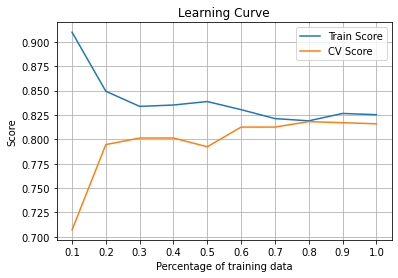

In [120]:
# Step 3.a: Decision Tree - learning curve
from sklearn.model_selection import learning_curve

decisionTreeClassifier_final = tree.DecisionTreeClassifier(
    max_depth = optimalDecisionTreeClassifier.best_params_['max_depth'], 
    ccp_alpha = optimalDecisionTreeClassifier.best_params_['ccp_alpha'])

train_sizes_abs, train_scores, test_scores = learning_curve(
    decisionTreeClassifier_final, 
    X, 
    y, 
    train_sizes = np.linspace(0.1,1.0,10))

plotFigure_plot("Learning Curve", "Percentage of training data", np.linspace(0.1,1.0,10), "Score", np.linspace(0.1,1.0,10), "titanic_decisionTree_learningCurve.png")


In [121]:
# Step 3.b: Neural Networks
from sklearn.neural_network import MLPClassifier

# bc ConvergenceWarning, set max_iter to something larger
MLPClassifier_initial = MLPClassifier(max_iter = 3000)

def plotFigure_semilogx(title, xLabel, xRange, yLabel, xTicks, saveAsName):
    plot.figure()
    plot.semilogx(xRange, np.mean(train_scores, axis=1), label = "Train Score")
    plot.semilogx(xRange, np.mean(test_scores, axis=1), label = "CV Score") 
    plot.legend()
    plot.title(title)
    plot.xlabel(xLabel)
    plot.ylabel(yLabel)
    # plot.xticks(xTicks)
    plot.grid()
    plot.savefig(saveAsName)
    plot.show()

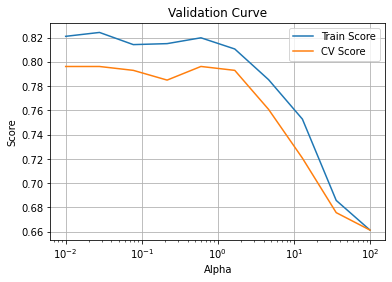

In [122]:
# Step 3.b: Neural Networks - Alpha (Penalty term for L2 regularization term)
# param_range, start with np.logspace(-1, 1, 5), the one in the example code, til found the one that show the "trend"
train_scores, test_scores = validation_curve(MLPClassifier_initial, X_train, y_train, param_name = 'alpha', param_range = np.logspace(-2, 2, 10))

plotFigure_semilogx("Validation Curve", "Alpha", np.logspace(-2, 2, 10), "Score", np.logspace(-2, 2, 10), "titanic_neuralNetworks_validationCurve_Alpha.png")

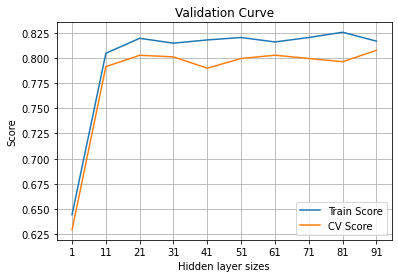

In [123]:
# Step 3.b: Neural Networks - Hidden layer sizes
train_scores, test_scores = validation_curve(MLPClassifier_initial, X_train, y_train, param_name = 'hidden_layer_sizes', param_range = np.arange(1,100, 10))

plotFigure_plot("Validation Curve", "Hidden layer sizes", np.arange(1,100, 10), "Score", np.arange(1,100, 10), "titanic_neuralNetworks_validationCurve_HiddenLayerSizes.png")


In [124]:
# Step 3.b: Neural Networks - Try to optimize the two hyper-parameters

param_grid = {'alpha': np.logspace(-2, 2, 10), 'hidden_layer_sizes': np.arange(1,100, 10)}
optimalMLPClassifier = GridSearchCV(MLPClassifier_initial, param_grid)

startTime1 = time.time()
optimalMLPClassifier.fit(X_train, y_train)
time_to_train[1] = time.time() - startTime1

print("Optimal hyper-parameters:",optimalMLPClassifier.best_params_)
print("time_to_train for neural networks:", time_to_train[1])

startTime2 = time.time()
performanceList[1] = accuracy_score(y_test, optimalMLPClassifier.predict(X_test))
time_to_predict[1] = time.time() - startTime2

print("Performance for the optimal neural networks model:", performanceList[1])
print("time_to_predict for neural networks:", time_to_predict[1])

Optimal hyper-parameters: {'alpha': 0.0774263682681127, 'hidden_layer_sizes': 61}
time_to_train for neural networks: 650.4394333362579
Performance for the optimal neural networks model: 0.8059701492537313
time_to_predict for neural networks: 0.005480289459228516


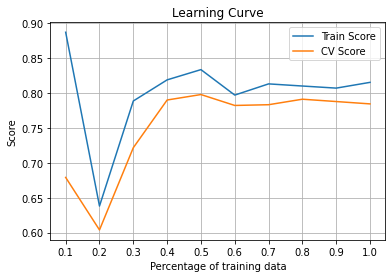

In [125]:
# Step 3.b: Neural Networks - learning curve 

MLPClassifier_final = MLPClassifier(
    alpha = optimalMLPClassifier.best_params_['alpha'], 
    hidden_layer_sizes = optimalMLPClassifier.best_params_['hidden_layer_sizes'],
    max_iter = 3000)

train_sizes_abs, train_scores, test_scores = learning_curve(
    MLPClassifier_final, 
    X, 
    y, 
    train_sizes = np.linspace(0.1,1.0,10))

plotFigure_plot("Learning Curve", "Percentage of training data", np.linspace(0.1,1.0,10), "Score", np.linspace(0.1,1.0,10), "titanic_neuralNetworks_learningCurve.png")


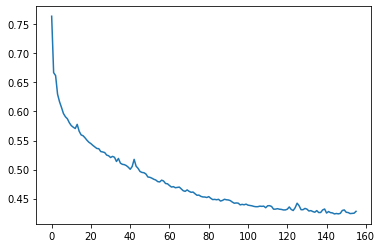

In [126]:
# Step 3.b: Neural Networks - loss curve 
MLPClassifier_final.fit(X, y)
loss_values = MLPClassifier_final.loss_curve_

plot.plot(loss_values)
plot.savefig("titanic_neuralNetworks_lossCurve.png")
plot.show()

In [127]:
# Step 3.c: ADABoosting
from sklearn.ensemble import AdaBoostClassifier

adaBoostClassifier = AdaBoostClassifier()

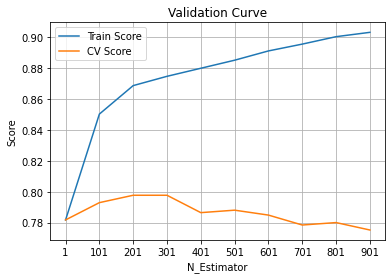

In [128]:
# Step 3.c: ADABoosting - n_estimators, number of weak learners
# param_range start with np.arange(1,100, 10), has tried several diff options, this is good enough to show the "trend"
train_scores, test_scores = validation_curve(adaBoostClassifier, X_train, y_train, param_name = 'n_estimators', param_range = np.arange(1,1000, 100))
    
plotFigure_plot("Validation Curve", "N_Estimator", np.arange(1,1000, 100), "Score", np.arange(1,1000, 100), "titanic_boosting_validationCurve_nEstimator.png")

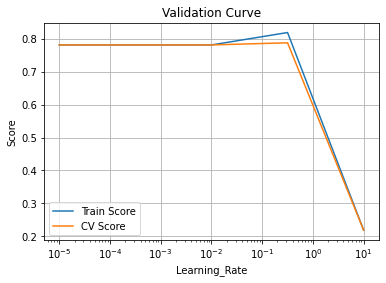

In [129]:
# Step 3.c: ADABoosting - learning_rate, to shrink the contribution of each sub-classifier
train_scores, test_scores = validation_curve(adaBoostClassifier, X_train, y_train, param_name = 'learning_rate', param_range = np.logspace(-5,1,5))
    
plotFigure_semilogx("Validation Curve", "Learning_Rate", np.logspace(-5,1,5), "Score", np.logspace(-5,1,5), "titanic_boosting_validationCurve_learningRate.png")

In [130]:
# Step 3.c: ADABoosting - Try to optimize the two hyper-parameters

param_grid = {'n_estimators': np.arange(1,1000, 100), 'learning_rate': np.logspace(-5,1,5)}
optimalAdaBoostClassifier = GridSearchCV(adaBoostClassifier, param_grid)

startTime1 = time.time()
optimalAdaBoostClassifier.fit(X_train, y_train)
time_to_train[2] = time.time() - startTime1

print("Optimal hyper-parameters:",optimalAdaBoostClassifier.best_params_)
print("time_to_train for adaBoosting:", time_to_train[2])

startTime2 = time.time()
performanceList[2] = accuracy_score(y_test, optimalAdaBoostClassifier.predict(X_test))
time_to_predict[2] = time.time() - startTime2

print("Performance for the ada boosting model:", performanceList[2])
print("time_to_predict for adaBoosting:", time_to_predict[2])

Optimal hyper-parameters: {'learning_rate': 0.31622776601683794, 'n_estimators': 101}
time_to_train for adaBoosting: 210.074369430542
Performance for the ada boosting model: 0.8134328358208955
time_to_predict for adaBoosting: 0.022983312606811523


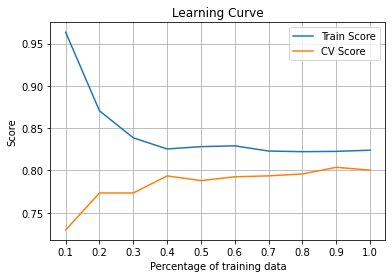

In [131]:
# Step 3.c: ADABoosting - learning curve 

AdaBoostClassifier_final = AdaBoostClassifier(
    n_estimators = optimalAdaBoostClassifier.best_params_['n_estimators'], 
    learning_rate = optimalAdaBoostClassifier.best_params_['learning_rate'])

train_sizes_abs, train_scores, test_scores = learning_curve(
    AdaBoostClassifier_final, 
    X, 
    y, 
    train_sizes = np.linspace(0.1,1.0,10))

plotFigure_plot("Learning Curve", "Percentage of training data", np.linspace(0.1,1.0,10), "Score", np.linspace(0.1,1.0,10), "titanic_adaBoosting_learningCurve.png")


In [132]:
# Step 3.d: SVM
from sklearn import svm

SVMClassifier_initial = svm.SVC()

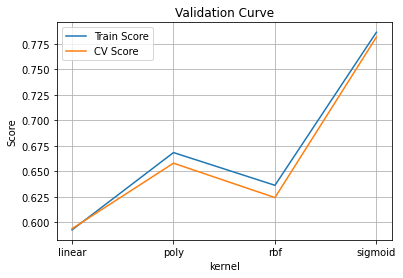

In [133]:
# Step 3.d: SVM - kernel 

train_scores, test_scores = validation_curve(SVMClassifier_initial, X_train, y_train, param_name='kernel', param_range = {"linear", "poly", "rbf", "sigmoid"})

plotFigure_label("Validation Curve", "kernel", [1, 2, 3, 4], "Score", ["linear", "poly", "rbf", "sigmoid"], "titanic_SVM_validationCurve_kernel.png")

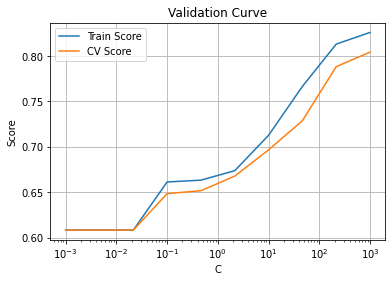

In [134]:
# Step 3.d: SVM - C, the strength of regulation

# have tried, degree, no convergence

train_scores, test_scores = validation_curve(SVMClassifier_initial, X_train, y_train, param_name = "C", param_range = np.logspace(-3,3,10))

plotFigure_semilogx("Validation Curve", "C", np.logspace(-3,3,10), "Score", np.logspace(-3,3,10), "titanic_SVM_validationCurve_c.png")

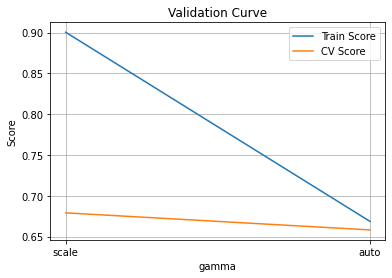

In [135]:
# Step 3.d: SVM - gamma, Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
# If you’re looking at C, you’ll likely want to consider gamma as well

train_scores, test_scores = validation_curve(SVMClassifier_initial, X_train, y_train, param_name = "gamma", param_range = {"scale", "auto"})

plotFigure_label("Validation Curve", "gamma", [1, 2], "Score", ["scale", "auto"], "titanic_SVM_validationCurve_gamma.png")

In [137]:
# Step 3.d: SVM - Try to optimize the three hyper-parameters

param_grid = {'kernel': ["linear", "poly", "rbf", "sigmoid"], 'C': np.logspace(-3,3,10), 'gamma': ["scale", "auto"]}
SVMBoostClassifier_optimal = svm.SVC(
                                C = 1000, 
                                gamma = "scale",
                                kernel = "linear")
startTime1 = time.time()
SVMBoostClassifier_optimal.fit(X_train, y_train)
time_to_train[2] = time.time() - startTime1

print("time_to_train for SVM:", time_to_train[2])

startTime2 = time.time()
performanceList[2] = accuracy_score(y_test, SVMBoostClassifier_optimal.predict(X_test))
time_to_predict[2] = time.time() - startTime2

print("Performance for the SVM model:", performanceList[2])
print("time_to_predict for SVM:", time_to_predict[2])

time_to_train for SVM: 71.49819850921631
Performance for the SVM model: 0.7910447761194029
time_to_predict for SVM: 0.004961490631103516


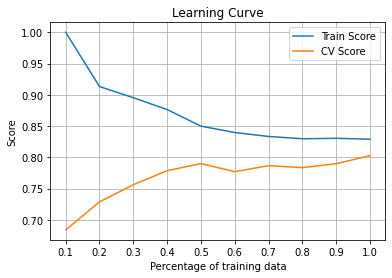

In [138]:
# Step 3.d: SVM - learning curve 
SVMClassifier_final = svm.SVC(
                        C = 1000, 
                        gamma = "scale",
                        kernel = "linear")

train_sizes_abs, train_scores, test_scores = learning_curve(
    AdaBoostClassifier_final, 
    X_train, 
    y_train, 
    train_sizes = np.linspace(0.1,1.0,10))

plotFigure_plot("Learning Curve", "Percentage of training data", np.linspace(0.1,1.0,10), "Score", np.linspace(0.1,1.0,10), "iris_SVM_learningCurve.png")

In [139]:
# Step 3.e: k-nearest neighbors 

from sklearn.neighbors import KNeighborsClassifier

KNNClassifier_inital = KNeighborsClassifier()

def plotFigure_xLabels(title, xLabel, xNumerical_list, xLabels_list, yLabel, saveAsName):
    plot.figure()
    x = xNumerical_list
    plot.plot(x, np.mean(train_scores, axis=1), label = "Train Score")
    plot.plot(x, np.mean(test_scores, axis=1), label = "CV Score") 
    plot.legend()
    plot.title(title)
    plot.xlabel(xLabel)
    plot.ylabel(yLabel)
    plot.xticks(x, xLabels_list)
    plot.grid()
    plot.savefig(saveAsName)
    plot.show()

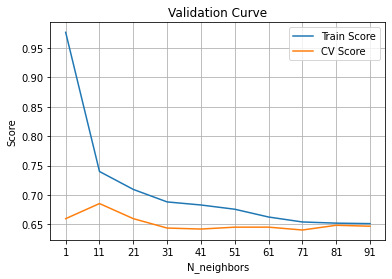

In [140]:
# Step 3.e: k-nearest neighbors  - n_neighbors
train_scores, test_scores = validation_curve(KNNClassifier_inital, X_train, y_train, param_name='n_neighbors', param_range = np.arange(1,100, 10))
    
plotFigure_plot("Validation Curve", "N_neighbors", np.arange(1,100, 10), "Score", np.arange(1,100, 10), "titanic_KNN_validationCurve_nNeighbors.png")

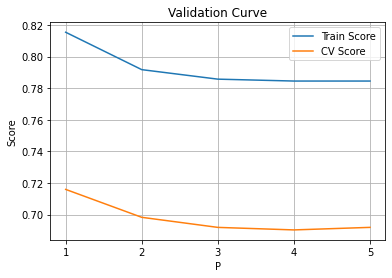

In [141]:
# Step 3.e: k-nearest neighbors  - p (Power parameter for the Minkowski metric)
# switch from weights to p
train_scores, test_scores = validation_curve(KNNClassifier_inital, X_train, y_train, param_name='p', param_range = np.arange(1,6))

plotFigure_plot("Validation Curve", "P", np.arange(1,6), "Score", np.arange(1,6), "titanic_KNN_validationCurve_p.png")

In [142]:
# Step 3.e: k-nearest neighbors - Try to optimize the two hyper-parameters

param_grid = {'n_neighbors': np.arange(1,100, 10), 'p': np.arange(1,6)}
KNNClassifier_optimal = GridSearchCV(KNNClassifier_inital, param_grid)

startTime1 = time.time()
KNNClassifier_optimal.fit(X_train, y_train)
time_to_train[4] = time.time() - startTime1

print("Optimal hyper-parameters:",KNNClassifier_optimal.best_params_)
print("time_to_train for K-NN:", time_to_train[4])

startTime2 = time.time()
performanceList[4] = accuracy_score(y_test, KNNClassifier_optimal.predict(X_test))
time_to_predict[4] = time.time() - startTime2

print("Performance for the K-NN model:", performanceList[4])
print("time_to_predict for K-NN tree:", time_to_predict[4])

Optimal hyper-parameters: {'n_neighbors': 11, 'p': 1}
time_to_train for K-NN: 3.0915045738220215
Performance for the K-NN model: 0.746268656716418
time_to_predict for K-NN tree: 0.011301994323730469


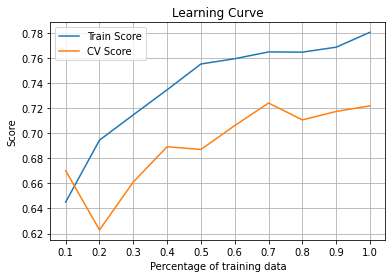

In [143]:
# Step 3.e: k-nearest neighbors - learning curve 

KNNClassifier_final = KNeighborsClassifier(
    n_neighbors = KNNClassifier_optimal.best_params_['n_neighbors'], 
    p = KNNClassifier_optimal.best_params_['p'])

train_sizes_abs, train_scores, test_scores = learning_curve(
    KNNClassifier_final, 
    X, 
    y, 
    train_sizes = np.linspace(0.1,1.0,10))

plotFigure_plot("Learning Curve", "Percentage of training data", np.linspace(0.1,1.0,10), "Score", np.linspace(0.1,1.0,10), "titanic_KNN_learningCurve.png")